# The RUS Gate

As we explored in the [Entanglement Generation](entanglement_generation.ipynb) advanced tutorial, a spin-photon interface such as a trion system can allow for the generation of entanglement between remote emitter spin qubits. It turns out that certain kinds of spin-photon interfaces can also allow for photon-mediated gates to be performed between the spin qubits, such as a control-Z rotation (CZ). This is generally much more difficult to accomplish than just entanglement generation because the interaction must be correct for any initial state of the spins, not just a predefined one that allows for the systems to become entangled.

## Theory background

This notebook explores one such approach that uses the polarization selection rules of the trion emitter along with an entangling circuit to implement a CZ gate. This gate was recently proposed as the main entangling gate in a spin-photon hybrid quantum computing architecture [[G. de Gliniasty et al., arXiv:2311.05605 (2023)](https://arxiv.org/abs/2311.05605)]. As with most interactions mediated by detecting photons, this CZ gate is naturally probabilistic. However, in the ideal case where no photons are lost, a failure of the gate does not actually destroy the state of the spin qubits. This opens the possibility to repeat until success (RUS), following the ideas proposed in 2005 [[Y. L. Lim et al., Phys. Rev. Lett. 95, 030505 (2005)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.95.030505)].

Instead of introducing the theory outright, a reader is invited to look at these two references. In any case, the necessary principles will be introduced when needed throughout this notebook.

## Entangling circuit

In [51]:
from zpgenerator import *
import qutip as qt
import numpy as np
import perceval as pcvl
import perceval.components.unitary_components as comp
import matplotlib.pyplot as plt

First, we will use Perceval to construct the linear-optical circuit we need to implement the photonic part of the RUS gate. This circuit is taken directly from Ref. [[G. de Gliniasty et al., arXiv:2311.05605 (2023)](https://arxiv.org/abs/2311.05605)].

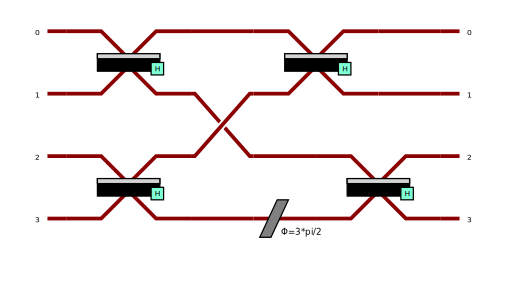

In [52]:
c = pcvl.Circuit(4)
c.add(0, pcvl.BS.H())
c.add(2, pcvl.BS.H())
c.add([0, 1, 2, 3], comp.PERM([0, 2, 1, 3]))
c.add(3, pcvl.PS(-np.pi/2))
c.add(0, pcvl.BS.H())
c.add(2, pcvl.BS.H())
pcvl.pdisplay(c)

Using the from_perceval() class method of the Circuit class in ZPGenerator, we can convert the Perceval circuit into a ZPGenerator circuit.

In [53]:
c_rus = Circuit.from_perceval(c)

## Building the processor

Now, let's create the trion source. Similar to the polarization encoding example in the [Entanglement Generation](entanglement_generation.ipynb) tutorial, we must configure our trion source to be excited by horizontally-polarized light and collected in the R/L polarization basis. Since we are driving both R and L transitions, the effective $\pi$-pulse condition will correspond to a pulse area of $\sqrt{2}\pi$.

In [54]:
trion = Source.trion()
trion.update_default_parameters(parameters={'theta': 0, 'phi': 0, 'theta_c': np.pi / 4, 'phi_c': -np.pi / 2, 'area': np.sqrt(2) * np.pi})

Now we can build the Processor with four number-resolving detectors monitoring the output of the RUS circuit.

In [55]:
p_rus = Processor() // ([0, 2], trion) // c_rus // (list(range(4)), Detector.pnr(2))

To simulate the conditional channels associated with this photon-mediated spin gate, we must determine the spin basis of the two-qubit system. We can first take the ground states from the trion source, and then take the tensor product to obtain the list of 4 basis states for the two-source system.

In [56]:
basis = [trion.states['|spin_up>'], trion.states['|spin_down>']]
basis = [qt.tensor(b1, b2) for b1 in basis for b2 in basis]  # take tensor products

Now we are set up to simulate the conditional channels. Similar to the entanglement generation polarization encoding example notebook, we can select just the spin degree of freedom and trace away the atomic degree of freedom. For our two-trion system, the spin degrees correspond to indices 1 and 3.

In [57]:
channels = p_rus.conditional_channels(basis=basis, select=[1, 3])

Just like that, we now have all conditional channels that evolve the two-spin space under the action of the RUS gate. For example, we expect the outcome (1, 0, 1, 0) to correspond to a successful CZ gate up to a local rotation. This means that we should be able to apply it to an initially unentangled state and find that it becomes entangled up to a re-normalization.

Note that conditional_channels returns a dictionary of Qobj objects. To learn how to manipulate these, please see the [QuTiP documentation](https://qutip.org/docs/latest/apidoc/classes.html).

In [64]:
initial_state = (qt.fock(2, 0) + qt.fock(2, 1)) / np.sqrt(2)  # spin superposition
initial_state = qt.tensor(initial_state, initial_state)  # initial state of two-qubit system (unentangled)
final_state = channels[1, 0, 1, 0](initial_state)  # apply the channel to the initial state
entanglement_efficiency = abs(final_state.tr())  # the probability of the condition is simply the trace of the final state
print('Efficiency:', entanglement_efficiency)
final_state = final_state / entanglement_efficiency  # To post-select, we normalize the final state
print('Concurrence:', qt.concurrence(final_state))
final_state.tidyup(1e-5)

Efficiency: 0.12500029027605536
Concurrence: 0.9999950212841616


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.25      +0.j          0.        -0.24999904j  0.        +0.24999865j
  -0.24999983+0.j        ]
 [ 0.        +0.24999893j  0.25000003+0.j         -0.24999982+0.j
   0.        -0.24999898j]
 [ 0.        -0.24999904j -0.24999982+0.j          0.24999999+0.j
   0.        +0.24999862j]
 [-0.24999989+0.j          0.        +0.24999873j  0.        -0.24999854j
   0.24999998+0.j        ]]

As we can see, the outcome (1, 0, 1, 0) occurs with a probability of 1/8 and produces a maximally entangled spin state.

## Local corrections

Similar to Bell-state measurements and fundamental to quantum communication, there are multiple outcomes that indicate a successful gate was applied to the qubits but only up to local corrections. Without corrections, averaging over all the successful outcomes will produce a channel that does not perform the desired gate. Let's illustrate this explicitly by averaging over all the successful outcomes and seeing what it does to our initial state.

In [65]:
successes = [(0, 1, 0, 1), (0, 1, 1, 0), (1, 0, 0, 1), (1, 0, 1, 0)]
channel_success = sum(channels[success] for success in successes)
final_state = channel_success(initial_state)
entanglement_efficiency = abs(final_state.tr())
print('Efficiency:', entanglement_efficiency)
final_state = final_state / entanglement_efficiency
print('Concurrence:', qt.concurrence(final_state))
final_state.tidyup(1e-5)

Efficiency: 0.5000011131732003
Concurrence: 0


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.24999999  0.          0.         -0.24999985]
 [ 0.          0.25000001 -0.24999983  0.        ]
 [ 0.         -0.24999983  0.25        0.        ]
 [-0.24999988  0.          0.          0.25000001]]

We can see that we get a successful outcome with a 1/2 probability but the average state of the spin qubits is completely unentangled. This particular effect of destroying the entanglement by averaging the outcomes is the exact reason why faster-than-light communication cannot be achived using quantum communication. To recover an entangled state, it is necessary to communicate which outcome was observed in order to perform local corrections on the spin qubits. The corrections for each case are given in [[G. de Gliniasty et al., arXiv:2311.05605 (2023)](https://arxiv.org/abs/2311.05605)]. For (1, 0, 1, 0) and (0, 1, 0, 1), the correction is $S_aS_b^\dagger$ where $S_i=\sqrt{Z_i}$ and $Z_i$ is the Pauli Z gate applied to spin qubit $i$. For the other two successful outcomes (0, 1, 1, 0) and (1, 0, 0, 1), the correction is simply the conjugate $S_a^\dagger S_b$. We could, in principle, evaluate these local channels by simulating the time dynamics. If they are accomplished deterministically and without measuring light, a realistic local gate can be simulated using the devices module in qutip rather than ZPGenerator. For this example, we will simply construct the ideal gates using the qip.circuit module in qutip.

In [66]:
sa = qt.qip.circuit.Gate(name='RZ', targets=[0], arg_value=np.pi / 2)
sb_dag = qt.qip.circuit.Gate(name='RZ', targets=[1], arg_value=-np.pi / 2)
c = qt.qip.circuit.QubitCircuit(2)
c.add_gate(sa)
c.add_gate(sb_dag)
correction = prod(c.propagators())
correction_1 = qt.sprepost(correction, correction.dag())
correction_2 = correction_1.dag()

We can now average over the channels after having applied the appropriate corrections to obtain to total successful channel.

In [68]:
successes =  {(0, 1, 0, 1): correction_1, (0, 1, 1, 0): correction_2, (1, 0, 0, 1): correction_2, (1, 0, 1, 0): correction_1}
channel_success = sum(correction * channels[outcome] for outcome, correction in successes.items())
final_state = channel_success(initial_state)
entanglement_efficiency = abs(final_state.tr())
print('Efficiency:', entanglement_efficiency)
final_state = final_state / entanglement_efficiency
print('Concurrence:', qt.concurrence(final_state))
final_state.tidyup(1e-5)

Efficiency: 0.5000011131732003
Concurrence: 0.9999952186737039


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.24999999  0.24999888  0.24999888 -0.24999985]
 [ 0.24999888  0.25000001  0.24999983 -0.24999888]
 [ 0.24999888  0.24999983  0.25       -0.24999888]
 [-0.24999988 -0.24999888 -0.24999888  0.25000001]]

As we can see, the channel now appears to perform a successful CZ gate with a probability of 1/2 as desired. However, to be sure that we have a CZ gate and are not simply replicating the action of a CZ on one initial state, we must check the fidelity of our channel.

## Gate fidelity

To understand how close our protocol implements a CZ gate, we can look at the average gate fideity, which is the average fidelity of the output state of the channel relative to the ideal state given a Haar random input state. This average gate fidelity can be computed using qutip once we have simulated our channel using ZPGenerator.

First, let's construct the ideal CZ gate for reference, using QuTiP.

In [69]:
cz = qt.qip.circuit.Gate(name='CZ', targets=[0], controls=[1])
gate_ideal = qt.qip.circuit.QubitCircuit(2)
gate_ideal.add_gate(cz)
gate_ideal = gate_ideal.propagators()[0]
print(gate_ideal)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]


Since the channel we simulated is probabilistic, it is not normalized. This must be taken into account when comparing it to a deterministic gate, such as the CZ gate. For any trace-preserving (TP) channel, i.e. a deterministic channel, the trace of the channel's Choi matrix representation should be unity. The Choi matrix can be computed using the qutip function super_to_choi(), albeit qutip follows a convention where the trace of a TP Choi matrix is $2^d$ where $d$ is the number of qubits. Taking this into account, we can renormalize the successful channel so that it is trace preserving.

In [70]:
norm = qt.super_to_choi(channel_success).tr() / 4
channel_success_TP = channel_success / norm

Now, we can use qutip to compute the average gate fidelity of the normalized simulated channel and the ideal CZ gate.

In [71]:
qt.average_gate_fidelity(channel_success_TP, gate_ideal)

0.9999980912954907

As we can see, the protocol we simulated indeed performs a CZ gate with an average gate fidelity of unity to within the precision of the simulation.

A different perspective is to first compute the error channel, which is the same as applying the simulated channel followed by the inverse channel corresponding to the ideal gate. This inverse ideal channel can be computed by converting the ideal CZ gate into a superoperator using sprepost function in qutip.

In [72]:
channel_error = qt.sprepost(gate_ideal.dag(), gate_ideal) * channel_success_TP

Notably, we can see that the error channel is the identity channel, which corresponds to the fact that the ideal inverse exactly cancels the simulated channel. To get a better visualization of this, we can convert the error channel into the $\chi$ representation in the Pauli basis and then plot the elements.

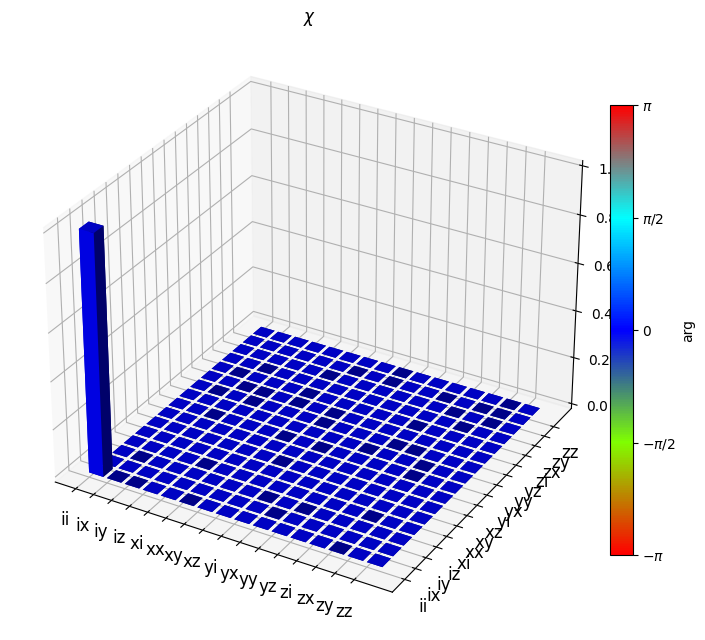

In [73]:
pauli_basis = [[qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]] * 2
pauli_labels = [["i", "x", "y", "z"]] * 2
chi = qt.qpt(channel_error, op_basis_list=pauli_basis)
qt.qpt_plot_combined(chi, lbls_list=pauli_labels)
plt.show()

This illustration clearly shows that the identity component is unity while all other Pauli operators are zero, indicating a noiseless channel.

## Repeat until success

An interesting feature of this implementation of a CZ gate is that some outcomes that do not implement the gate, such as (2, 0, 0, 0), do not actually dephase the qubit states. That is, the purity of the final spin-spin state is still unity, indicating that it can be 'reset' using an appropriate correction. A type of outcome such as this is known as a 'failure with insurance', rather than a complete failure. Let's take a look at the purity along with the concurrence for all possible outcomes:

In [87]:
print("{:<12} | {:<7} | {:<5} | {:}".format('Outcome',  'Eff.', 'Purity', 'Concurrence'))
for k, channel in channels.items():
    final_state = channel(initial_state)
    eff = abs(final_state.tr())
    if eff > 10**-5:
        final_state = final_state / eff
        print("{:<12} | {:.5f} | {:.4f} | {:.5f}".format(str(k), eff, (final_state * final_state.dag()).tr(), qt.concurrence(final_state)))

Outcome      | Eff.    | Purity | Concurrence
(0, 0, 0, 2) | 0.12500 | 1.0000 | 0.00000
(0, 0, 2, 0) | 0.12500 | 1.0000 | 0.00000
(0, 1, 0, 1) | 0.12500 | 1.0000 | 1.00000
(0, 1, 1, 0) | 0.12500 | 1.0000 | 1.00000
(0, 2, 0, 0) | 0.12500 | 1.0000 | 0.00000
(1, 0, 0, 1) | 0.12500 | 1.0000 | 1.00000
(1, 0, 1, 0) | 0.12500 | 1.0000 | 1.00000
(2, 0, 0, 0) | 0.12500 | 1.0000 | 0.00000


As we can see, outcomes that give zero concurrence actually produce states that are still pure. To know what gate we are applying when we detect outcome (2, 0, 0, 0), for example, we can again visualize its $\chi$ matrix.

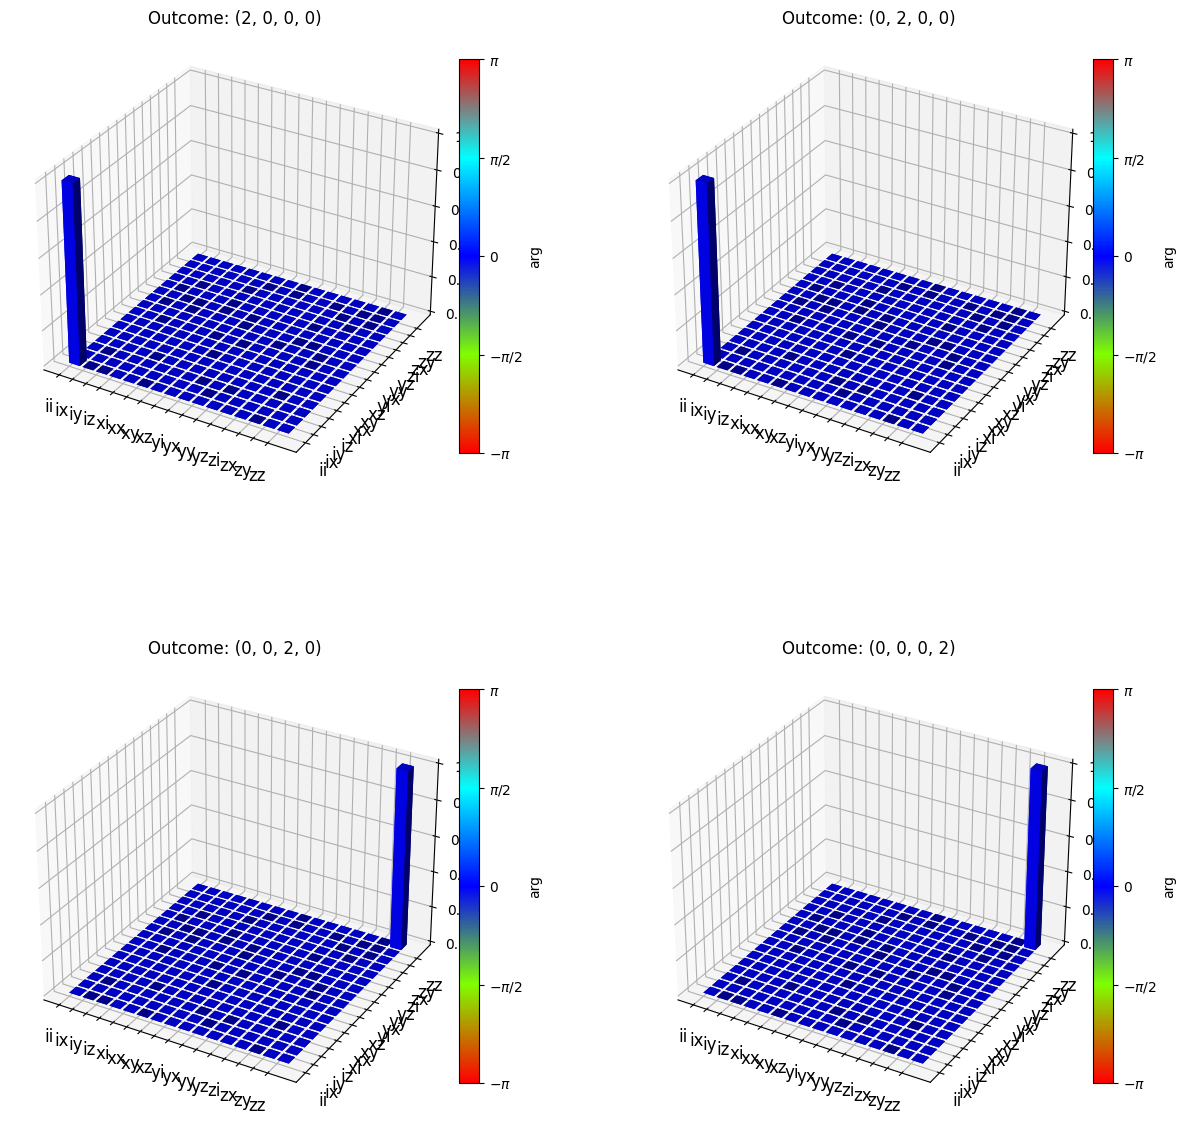

In [88]:
failures = [(2, 0, 0, 0), (0, 2, 0, 0), (0, 0, 2, 0), (0, 0, 0, 2)]
fig = plt.figure(figsize=(15, 15))
for i, outcome in enumerate(failures):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    qt.qpt_plot_combined(qt.qpt(4 * channels[outcome] / qt.super_to_choi(channels[outcome]).tr(), op_basis_list=pauli_basis),
                         lbls_list=pauli_labels, ax=ax, figsize=(2, 2), title='Outcome: ' + str(outcome))
plt.show()

Here we can see that outcomes (2, 0, 0, 0) and (0, 2, 0, 0) perform the identity while outcomes (0, 0, 2, 0) and (0, 0, 0, 2) perform a separable $Z_aZ_b$ gate, which is consistent with [[G. de Gliniasty et al., arXiv:2311.05605 (2023)](https://arxiv.org/abs/2311.05605)]. This means that we can reset these failures by applying the inverse transformation, which is just $Z_aZ_b$ for those latter two outcomes. Once that is done, we can run the protocol again. In principle, this can be repeated as many times as we want. In this ideal scenario, we either have a success or a failure with insurance. Thus, by repeating many times, we can approach a gate efficiency of 100%. This is the main underlying idea behind the Repeat Until Success (RUS) gate.

Let's make a dictionary for the gates needed to reset after a failure with insurance.

In [89]:
c = qt.qip.circuit.QubitCircuit(2)
c.add_gate(qt.qip.circuit.Gate(name='Z', targets=[0]))
c.add_gate(qt.qip.circuit.Gate(name='Z', targets=[1]))
reset_ZZ = prod(c.propagators())
reset_ZZ = qt.sprepost(reset_ZZ, reset_ZZ.dag())
reset_II = qt.qeye([[2, 2], [2, 2]])  # identity superoperator
retries = {(2, 0, 0, 0): reset_II, (0, 2, 0, 0): reset_II, (0, 0, 2, 0): reset_ZZ, (0, 0, 0, 2): reset_ZZ}

Now that we have all the information, we can write a recursive algorithm to compute the final successful channel after $N$ gate attempts.

In [90]:
def rus_channel(N: int, conditional_channels) -> Qobj:
    assert N > 0, "Number of attempts must be positive."
    channel_success = sum(correction * conditional_channels[outcome] for outcome, correction in successes.items())
    return channel_success if N == 1 else channel_success + rus_channel(N - 1, conditional_channels) * sum(correction * conditional_channels[outcome] for outcome, correction in retries.items())

From this perspective, the RUS gate can be considered a deterministic gate where any remaining inefficiency due to truncating $N$ is simply considered infidelity. So, let's now look at the average gate fidelity of the RUS gate as a function of the number of attempts.

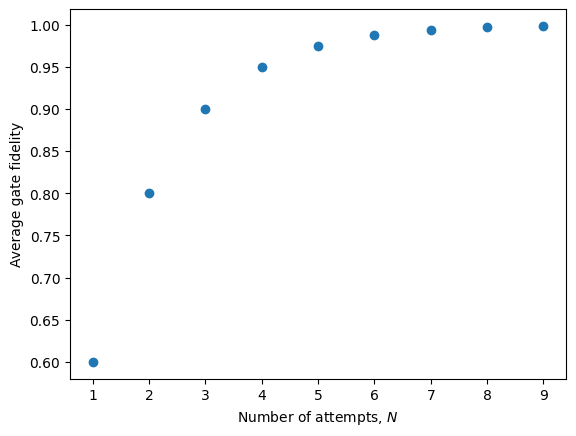

In [91]:
fidelity = [qt.average_gate_fidelity(rus_channel(N, channels), gate_ideal) for N in range(1, 10)]
plt.scatter(range(1, 10), fidelity)
plt.xlabel('Number of attempts, $N$')
plt.ylabel('Average gate fidelity')
plt.show()

Notice that, quite quickly, the RUS protocol achieves an almost perfect fidelity. To get a better idea of the scaling, let's look at the error on a log scale plot.

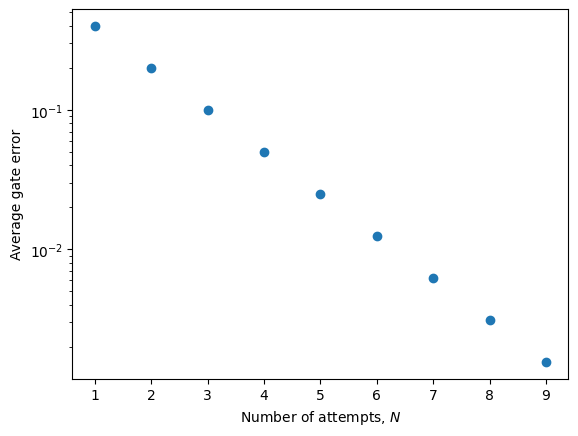

In [92]:
fidelity = [1 - qt.average_gate_fidelity(rus_channel(N, channels), gate_ideal) for N in range(1, 10)]
_, ax = plt.subplots()
ax.scatter(range(1, 10), fidelity)
ax.set_yscale('log')
ax.set_xlabel('Number of attempts, $N$')
ax.set_ylabel('Average gate error')
plt.show()

Now it is more clear that the error is suppressed exponentially fast with increasing number of attempts. To achieve a fidelity of greater than 99%, only 7 attempts are required in the ideal case. For 99.9%, 10 attempts are required.

## Imperfections

Now that we have fully analyzed the perfect implementation of the RUS gate, we can start to simulate noisy implementations. Note that, once we start to add imperfections, there can be many more outcomes than are possible in the ideal case. These additional outcomes might not all be complete failures, some might be failures with insurance. This aspect introduces a substantial amount of richness and complexity into the problem, which is where ZPGenerator can be useful.

### Pure dephasing


Since ZPGenerator is designed to facilitate easy exploration of physical parameters, all we need to do is modify the parameters when simulating our channel. Let's first add some emitter pure dephasing to see what happens to the average gate fidelity. For now, let's use the exact same protocol as we derived in the ideal case.

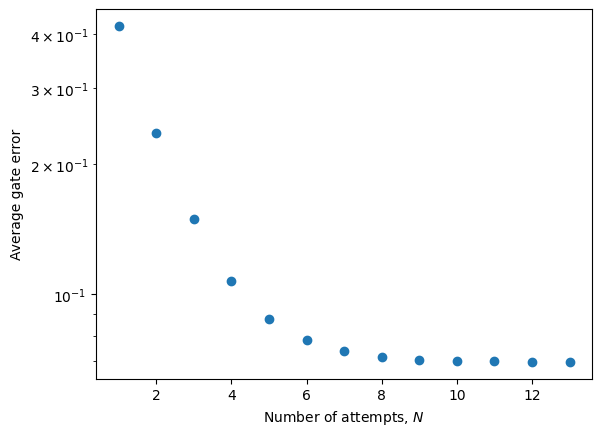

In [93]:
channels_imperfect = p_rus.conditional_channels(parameters={'dephasing': 0.1}, basis=basis, select=[1, 3])

fidelity = [1 - qt.average_gate_fidelity(rus_channel(N, channels_imperfect), gate_ideal) for N in range(1, 14)]

_, ax = plt.subplots()
ax.scatter(range(1, 14), fidelity)
ax.set_yscale('log')
ax.set_xlabel('Number of attempts, $N$')
ax.set_ylabel('Average gate error')
plt.show()

We can immediately see that, under the current protocol, the presence of emitter pure dephasing prevents us from arbitrarily improving the gate fidelity by increasing the number of attempts. However, the presence of dephasing actually reduces the amount of bunching, allowing for additional outcomes. Copying down the code we used to analyze the perfect case, we can now identify these new outcomes and how the spin state is affected.

In [94]:
print("{:<12} | {:<7} | {:<5} | {:}".format('Outcome',  'Eff.', 'Purity', 'Concurrence'))
for k, channel in channels_imperfect.items():
    final_state = channel(initial_state)
    eff = abs(final_state.tr())
    if eff > 10**-5:
        final_state = final_state / eff
        print("{:<12} | {:.5f} | {:.4f} | {:.5f}".format(str(k), eff, (final_state * final_state.dag()).tr(), qt.concurrence(final_state)))

Outcome      | Eff.    | Purity | Concurrence
(0, 0, 0, 2) | 0.11932 | 1.0000 | 0.00000
(0, 0, 1, 1) | 0.01136 | 1.0001 | 0.00000
(0, 0, 2, 0) | 0.11932 | 1.0000 | 0.00000
(0, 1, 0, 1) | 0.12500 | 0.9132 | 0.90909
(0, 1, 1, 0) | 0.12500 | 0.9132 | 0.90909
(0, 2, 0, 0) | 0.11932 | 1.0000 | 0.00000
(1, 0, 0, 1) | 0.12500 | 0.9132 | 0.90909
(1, 0, 1, 0) | 0.12500 | 0.9132 | 0.90909
(1, 1, 0, 0) | 0.01136 | 1.0000 | 0.00000
(2, 0, 0, 0) | 0.11932 | 1.0000 | 0.00000


Notably, there are now outcomes (0, 0, 1, 1) and (1, 1, 0, 0) due to the failure of Hong-Ou-Mandel (HOM) bunching. Interestingly, these 'HOM failures' actually still maintain the purity of the spin state, meaning there is a chance to recover them. This is because, for example, the outcome (1, 1, 0, 0) would have otherwise caused outcome (2, 0, 0, 0) or (0, 2, 0, 0) but both of these cases require the same reset correction and so there is no need to distinguish which one we should have observed. This means we can simply modify our list of retries and the associated reset corrections to include these two additional outcomes.

In [95]:
retries.update({(1, 1, 0, 0): reset_II, (0, 0, 1, 1): reset_ZZ})

Now, let's see how this change impacts our fidelity.

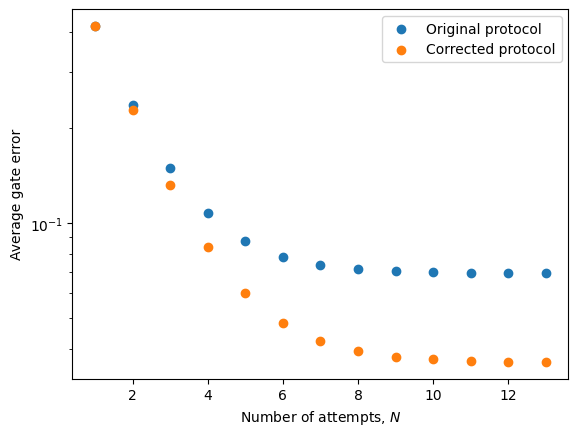

In [96]:
channels_imperfect = p_rus.conditional_channels(parameters={'dephasing': 0.1}, basis=basis, select=[1, 3])

fidelity_mod = [1 - qt.average_gate_fidelity(rus_channel(N, channels_imperfect), gate_ideal) for N in range(1, 14)]

_, ax = plt.subplots()
ax.scatter(range(1, 14), fidelity, label='Original protocol')
ax.scatter(range(1, 14), fidelity_mod, label='Corrected protocol')
ax.set_yscale('log')
ax.set_xlabel('Number of attempts, $N$')
ax.set_ylabel('Average gate error')
plt.legend()
plt.show()

As we can see, by considering the additional two failures caused by photon distinguishability, we have managed to improve the average gate fidelity significantly. However, the presence of dephasing still prevents an arbitrary improvement in fidelity, and this is due to how it impacts the successful outcomes which we cannot compensate for by modifying our selection and correction protocol.

With this new protocol, let's see how the asymptotic fidelity (say at $N=100$) depends on the indistinguishability of photons produced by the emitters. To do this, we must compute both the indistinguishability and the gate fidelity as we vary the emitter pure dephasing rate.

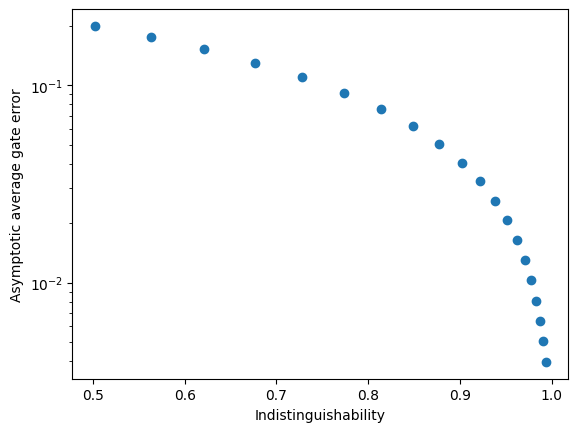

In [97]:
dephasing_rates = np.logspace(-2, 0, 20)
asymptotic_error = []
hom_list = []
for rate in dephasing_rates:
    params = {'dephasing': rate}
    hom_list.append(trion.hom(parameters=params)['M'])
    channels_imperfect = p_rus.conditional_channels(parameters=params, basis=basis, select=[1, 3])
    asymptotic_error.append(1 - qt.average_gate_fidelity(rus_channel(100, channels_imperfect), gate_ideal))

_, ax = plt.subplots()
ax.scatter(hom_list, asymptotic_error)
ax.set_yscale('log')
ax.set_xlabel('Indistinguishability')
ax.set_ylabel('Asymptotic average gate error')
plt.show()

Since ZPGenerator provides us with the full noisy channel, we can get a lot more information about exactly what goes wrong by looking at the error channel. Let's use a reasonable value of 0.1 for the pure dephasing, corresponding to a indistinguishability of around 91%. This reflects a common lab setting.

In [98]:
params = {'dephasing': 0.1}
ind = trion.hom(parameters=params)['M']
print('Indistinguishability: ', ind)
channels_imperfect = p_rus.conditional_channels(parameters=params, basis=basis, select=[1, 3])
channel_rus = rus_channel(100, channels_imperfect)
channel_err = qt.sprepost(gate_ideal.dag(), gate_ideal) * channel_rus

Indistinguishability:  0.9126667573663786


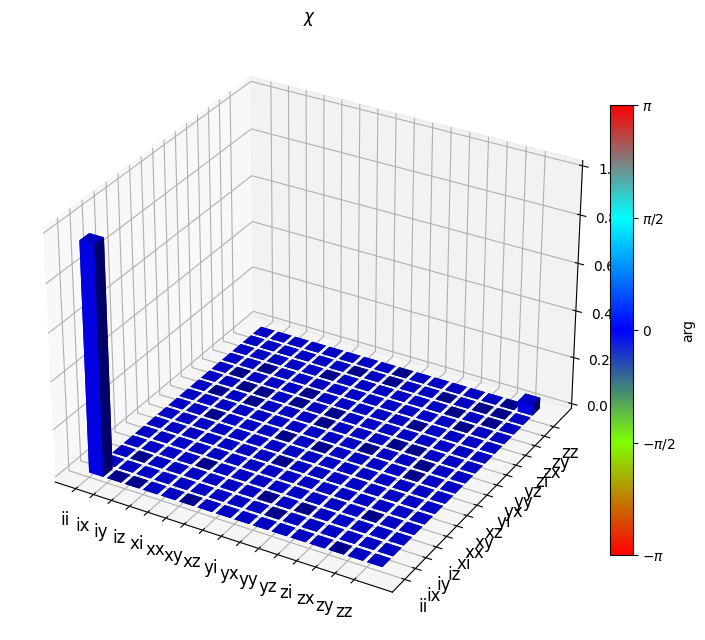

In [99]:
qt.qpt_plot_combined(qt.qpt(channel_err, op_basis_list=pauli_basis), lbls_list=pauli_labels)
plt.show()

We can see that the presence of dephasing causes a $Z_aZ_b$ correlated dephasing error on the spin qubits.

### Realistic excitation pulses

Let's now take a look at using a more realistic excitation pulses that may cause multi-photon emission. To do this, we need to rebuild our processor using a different pulse shape. Let's use a square pulse because it captures globally the same physics as a Gaussian pulse but is faster to simulate.

In [100]:
trion = Source.trion(pulse=Pulse.square(parameters={'width': 0.1}), parameters={'theta': 0, 'phi': 0, 'theta_c': np.pi / 4, 'phi_c': -np.pi / 2, 'area': np.sqrt(2) * np.pi})
p_rus_pulse = Processor() // ([0, 2], trion) // c_rus // (list(range(4)), Detector.pnr(2))

Let's quickly take a look at the characterisation of our source.

In [101]:
trion.display_quality()

Number  | Probability
0       | 0.50012
1       | 0.49382
2       | 0.00605
3       | 0.00001
4       | 0.00000

Figure of Merit       | Value
Brightness            | 0.4999
Average photon number | 0.5060
Intensity correlation | 0.0475

Figure of Merit                | Value
First order number coherence   | 0.0066
Second order number coherence  | 0.0001
Hong-Ou-Mandel visibility      | 0.9292
Mean wavepacket overlap        | 0.9690



We can notice that using a more realistic pulse introduces a small probability of producing 2 photons for each excitation pulse. This gives an integrated intensity correlation of about 5%, which also reduces the indistinguishability characterised by the mean wavepacket overlap.

In [110]:
print("{:<12} | {:<6} | {:<5} | {:}".format('Outcome',  'Eff.', 'Purity', 'Concurrence'))
for k, channel in channels_imperfect.items():
    final_state = channel(initial_state)
    eff = abs(final_state.tr())
    if eff > 10**-4:
        final_state = final_state / eff
        print("{:<12} | {:.4f} | {:.4f} | {:.5f}".format(str(k), eff, (final_state * final_state.dag()).tr(), qt.concurrence(final_state)))

Outcome      | Eff.   | Purity | Concurrence
(0, 0, 0, 0) | 0.0051 | 0.3776 | 0.00000
(0, 0, 0, 1) | 0.0264 | 0.8566 | 0.00717
(0, 0, 0, 2) | 0.0977 | 0.9932 | 0.00000
(0, 0, 1, 0) | 0.0264 | 0.8566 | 0.00717
(0, 0, 1, 1) | 0.0183 | 0.9506 | 0.00000
(0, 0, 1, 2) | 0.0013 | 0.7336 | 0.67345
(0, 0, 2, 0) | 0.0977 | 0.9932 | 0.00000
(0, 0, 2, 1) | 0.0013 | 0.7336 | 0.67344
(0, 1, 0, 0) | 0.0259 | 0.9130 | 0.00000
(0, 1, 0, 1) | 0.1061 | 0.8405 | 0.82059
(0, 1, 0, 2) | 0.0012 | 0.8256 | 0.04553
(0, 1, 1, 0) | 0.1061 | 0.8405 | 0.82059
(0, 1, 1, 1) | 0.0024 | 0.8346 | 0.00000
(0, 1, 2, 0) | 0.0012 | 0.8256 | 0.04552
(0, 2, 0, 0) | 0.0970 | 0.9976 | 0.00000
(0, 2, 0, 1) | 0.0011 | 0.9679 | 0.95308
(0, 2, 1, 0) | 0.0011 | 0.9679 | 0.95307
(1, 0, 0, 0) | 0.0269 | 0.8901 | 0.00000
(1, 0, 0, 1) | 0.1074 | 0.8374 | 0.81867
(1, 0, 0, 2) | 0.0035 | 0.9388 | 0.01579
(1, 0, 1, 0) | 0.1074 | 0.8374 | 0.81867
(1, 0, 1, 1) | 0.0028 | 0.6601 | 0.00000
(1, 0, 2, 0) | 0.0035 | 0.9388 | 0.01579
(1, 1, 0, 0)

Right away we can notice that the realistic pulse produces many more outcomes than before due to the possibility of multi-photon emission. The pulse may also fail to excite the source entirely, leaving a small chance to see zero or one photon outcomes as well (even without including other losses). Interestingly, as for dephasing, we can see that many of the outcomes actually maintain a high purity for the spin state and some of the single-photon outcomes even indicate entanglement was achieved. This suggests that there may be a way to modify our protocol again in order to compensate for these additional noisy outcomes using corrections and repeat attempts. To keep things simple, however, we will just use the same protocol as for the pure dephasing case and see how the average gate fidelity depends on the intensity correlation of the source.

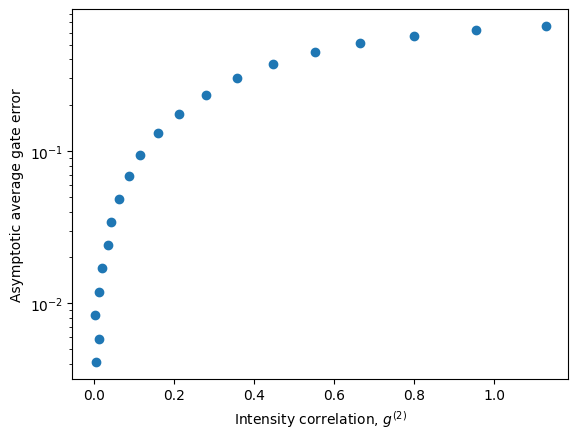

In [103]:
pulse_widths = np.logspace(-2, 1, 20)
asymptotic_error = []
g2_list = []
for width in pulse_widths:
    params = {'width': width}
    g2_list.append(trion.g2(parameters=params))
    channels_imperfect = p_rus_pulse.conditional_channels(parameters=params, basis=basis, select=[1, 3])
    asymptotic_error.append(1 - qt.average_gate_fidelity(rus_channel(100, channels_imperfect), gate_ideal))

_, ax = plt.subplots()
ax.scatter(g2_list, asymptotic_error)
ax.set_yscale('log')
ax.set_xlabel('Intensity correlation, $g^{(2)}$')
ax.set_ylabel('Asymptotic average gate error')
plt.show()

Lastly, let's take a look at the error channel's $\chi$ matrix representation to see roughly what is happening when we have multi-photon emission.

Intensity correlation:  0.0398240844410854


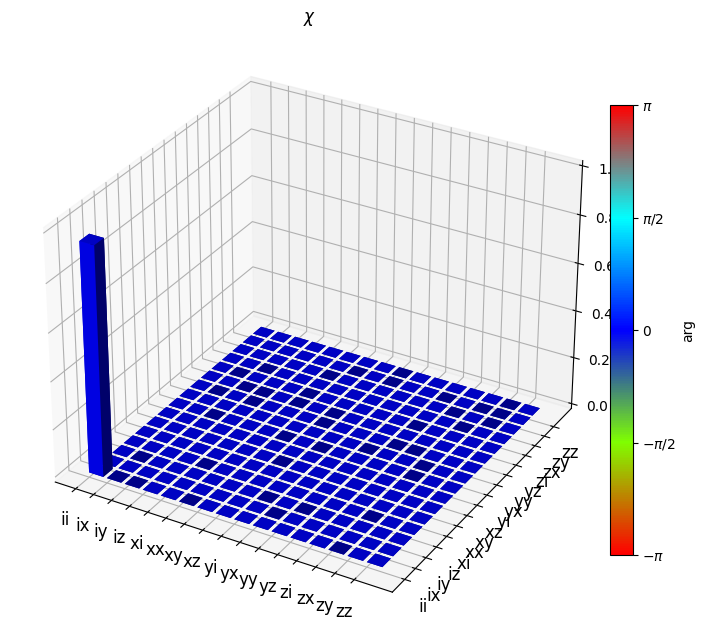

In [104]:
params = {'width': 0.1}
g2 = trion.g2(parameters=params)
print('Intensity correlation: ', g2)
channels_imperfect = p_rus_pulse.conditional_channels(parameters=params, basis=basis, select=[1, 3])
channel_rus = rus_channel(100, channels_imperfect)
channel_err = qt.sprepost(gate_ideal.dag(), gate_ideal) * channel_rus
chi_err = qt.qpt(channel_err, op_basis_list=pauli_basis)
qt.qpt_plot_combined(chi_err, lbls_list=pauli_labels)
plt.show()

Surprisingly, we can see that the only problem with our error channel is that the weight of the identity is not 1. This means that the presence of multi-photon emission, at least in small amounts, causes an effective inefficiency as its dominant effect. This suggests it is possible to almost fully compensate for it using proper corrections. However, the situation becomes a bit more complicated if some loss is introduced into the system as it will reduce the ability to distinguish different multi-photon outcomes.

### Combined Imperfections

Let's now combine distinguishability, multi-photon emission, and losses together and see what kind of error channel we get.

In [105]:
trion = Source.trion(pulse=Pulse.square(), parameters={'theta': 0, 'phi': 0, 'theta_c': np.pi / 4, 'phi_c': -np.pi / 2, 'area': np.sqrt(2) * np.pi})
p_rus_combined = Processor() // ([0, 2], trion) // Circuit.loss(4, name='transmission') // c_rus // (list(range(4)), Detector.pnr(2))

Number  | Probability
0       | 0.50292
1       | 0.48540
2       | 0.01164
3       | 0.00004
4       | 0.00000

Figure of Merit       | Value
Brightness            | 0.4971
Average photon number | 0.5088
Intensity correlation | 0.0909

Figure of Merit                | Value
First order number coherence   | 0.0137
Second order number coherence  | 0.0003
Hong-Ou-Mandel visibility      | 0.7059
Mean wavepacket overlap        | 0.7968



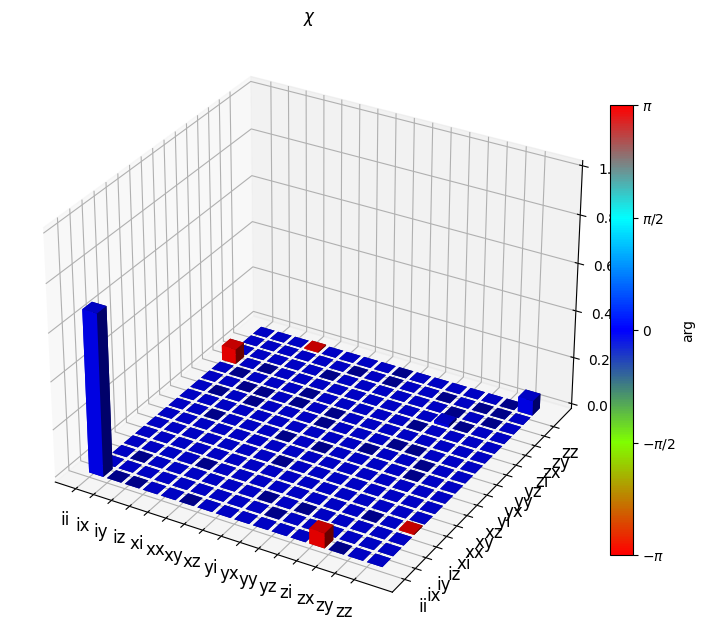

In [106]:
params = {'width': 0.2, 'dephasing': 0.2, 'transmission/efficiency': 0.8}
trion.display_quality(parameters=params)

channels_imperfect = p_rus_combined.conditional_channels(parameters=params, basis=basis, select=[1, 3])
channel_rus = rus_channel(100, channels_imperfect)
channel_err = qt.sprepost(gate_ideal.dag(), gate_ideal) * channel_rus
chi_err = qt.qpt(channel_err, op_basis_list=pauli_basis)
qt.qpt_plot_combined(chi_err, lbls_list=pauli_labels)
plt.show()

By including some significant sources of error, we can now see that the error channel becomes less trivial. However, it appears that, for this set of parameters, the dominant errors are all related to $Z$ and $I$ operations. This is likely a result of the symmetry of the protocol, and we might expect other types of errors to arise if the two sources are not fully identical, if the trion is not completely degenerate, or if the entangling circuit is not perfect. Although all these other sources of errors can be taken into account using ZPGenerator, it goes beyond the scope of this exercise.